In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier

## **Data**

In [3]:
df = pd.read_csv('sample_data.csv', delimiter=';')

1. Data for the analysis are stored in the csv file sample_data.csv
2. Assume that the mailing was delivered on October 1st, 2021 (time point is called t0 in the following)
3. The following variables are provided: 
    
- **ID**: Customer identifier 
- **Activated**: Every customer in the data set received a print mailing at t0 (i.e. on October 1st, 2021). If the customer made a purchase within the period of time p after t0, then the variable “Activated” assumes a value of 1, otherwise it assumes a value of 0. Note that receiving a print mailing is not the same as being a recipient of the newsletter (at t0), which is encoded by the variable Cust_NL (1 means that the customer was a newsletter recipient at t0, 0 means that the customer was not).
- **Cust_Age**: Customer age at t0
- **Cust_Gender**: Customer gender at t0
- **Cust_NL**: Did the customer receive our newsletter at t0? 
- **Orders**: Number of orders within 12 months before t0 
- **Orders_Voucher**: Number of orders in which a voucher was redeemed within 12 months before t0
- **LastOrder**: Date of the last order within 12 months before t0 

In [4]:
df.head()

,ID,Activated,Cust_Age,Cust_Gender,Cust_NL,Orders,LastOrder,Orders_Voucher
0,1,1,53,m,0,3,2021-07-24,0
1,2,0,46,f,0,2,2021-04-11,1
2,3,0,28,f,0,1,2021-01-14,0
3,4,1,53,f,0,3,2021-07-20,0
4,5,1,61,m,0,1,2021-05-25,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              10000 non-null  int64 
 1   Activated       10000 non-null  int64 
 2   Cust_Age        10000 non-null  int64 
 3   Cust_Gender     10000 non-null  object
 4   Cust_NL         10000 non-null  int64 
 5   Orders          10000 non-null  int64 
 6   LastOrder       9019 non-null   object
 7   Orders_Voucher  10000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 625.1+ KB


In [6]:
# change the LastOrder column from object to a datetime type
df['LastOrder'] = pd.to_datetime(df['LastOrder'])

In [7]:
# change the Cust_Gender column to binary encoding
df['is_female'] = np.where(df.Cust_Gender=='f', 1, 0)

In [8]:
df.head()

,ID,Activated,Cust_Age,Cust_Gender,Cust_NL,Orders,LastOrder,Orders_Voucher,is_female
0,1,1,53,m,0,3,2021-07-24,0,0
1,2,0,46,f,0,2,2021-04-11,1,1
2,3,0,28,f,0,1,2021-01-14,0,1
3,4,1,53,f,0,3,2021-07-20,0,1
4,5,1,61,m,0,1,2021-05-25,0,0


## **1. Which measure(s) would you use to evaluate the performance of the mailing?**

In [9]:
# Activation rate 
print(f'The Activation Rate for the group receving the print mailing is: \
{(df.Activated.sum()/df.Activated.count())*100}%')

The Activation Rate for the group receving the print mailing is: 43.49%


## **2. Can you determine factors which can explain if a customer gets activated by the mailing?**


In [10]:
features = ['Cust_Age', 'Cust_NL', 'Orders','Orders_Voucher', 'is_female']

In [11]:
# Compute the correlation matrix
correlation_matrix = df[features+['Activated']].corr()

# Select the correlation values for column 'A'
correlation_with_activated = correlation_matrix['Activated']

# Sort the correlation values in ascending order
correlation_with_activated = correlation_with_activated.sort_values(ascending=False)

In [12]:
correlation_with_activated

Activated         1.000000
Orders            0.425343
Orders_Voucher    0.252807
Cust_Age          0.102746
Cust_NL           0.055835
is_female         0.025418
Name: Activated, dtype: float64

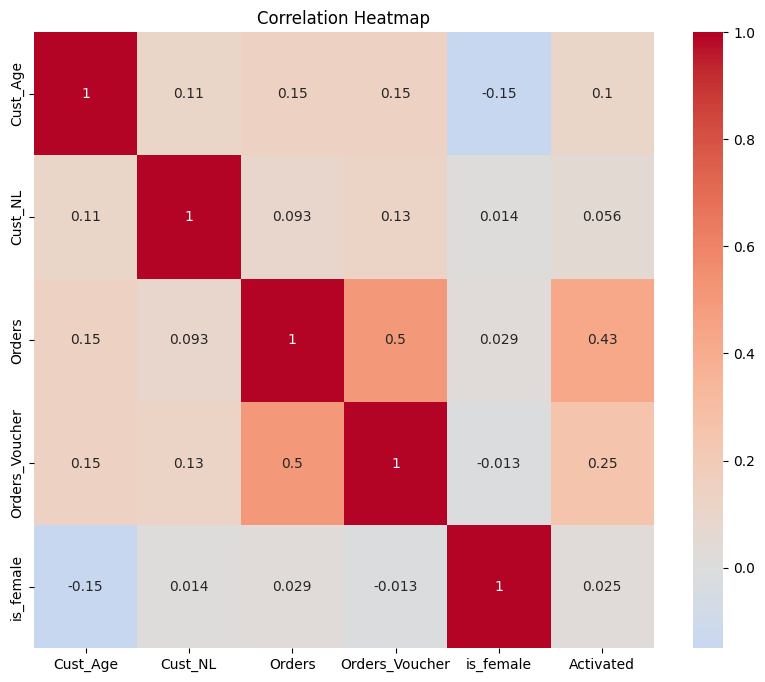

In [13]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.drop('Activated'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

Positive Correlation with Customer Activation:

    1. #orders in the last 12 months before t0 (p=0.43, moderate)
    
    2. #vouchers applied on orders in the last 12 months until t0 (p=0.25, low)
    
    3. customer age at the time t0 (p=0.1, low)

Furtheremore the multicollinerity should be checked since it is evident that `orders_voucher` and `orders` are moderate correlated.  

### Logistic Regression to identify the predictors of the customer's activation

In [14]:
# Selecting features and target
X = df[features]
y = df['Activated']

In [18]:
# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

         Variable       VIF
0        Cust_Age  3.719412
1         Cust_NL  1.245319
2          Orders  2.984388
3  Orders_Voucher  1.746382
4       is_female  2.753152


As rule of thumb the VIF should not be higher than 5. 

In this case we can exclude that there is  multicollinearity across predictors since for all of them the VIP is <5. 

In [19]:
# Adding constant for the intercept
X = sm.add_constant(X)

# Logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.574943
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Activated   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Jun 2024   Pseudo R-squ.:                  0.1602
Time:                        13:01:26   Log-Likelihood:                -5749.4
converged:                       True   LL-Null:                       -6846.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.9412      0.098    -19.734      0.000      -2.134      -1.748
Cust_Age         

In [20]:
#coefficients odds ratios
coefficients = result.params
odds_ratios = np.exp(coefficients)
print(odds_ratios)

const             0.143530
Cust_Age          1.006515
Cust_NL           1.035447
Orders            1.486541
Orders_Voucher    1.126690
is_female         1.114430
dtype: float64


## **3. Can you think of other factors, derived from the information in the sample, which could help explain the question at hand?**

In [21]:
## 1. additiona feature: day lag from the last order to t0
df['day_lag_from_last_order'] = (pd.to_datetime('2021-10-01') - df['LastOrder']  ).dt.days

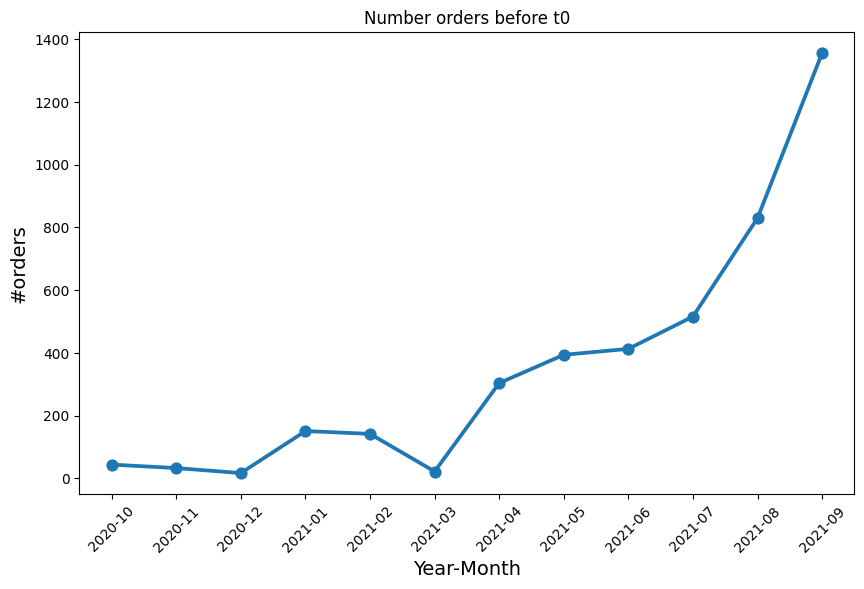

In [22]:
df['yyyy-mm'] = df['LastOrder'].dt.to_period('M')
data = df.groupby(['yyyy-mm']).Activated.sum().reset_index()

# plot the orders' sum for each month
fontsize = 14
plt.figure(figsize=(10, 6))
sns.pointplot(data=data, x='yyyy-mm', y='Activated')
plt.title('Number orders before t0')
plt.xlabel('Year-Month', fontsize=fontsize)
plt.ylabel('#orders', fontsize=fontsize)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

On the grapoh the sum of orders are diplayed based on year-month. 

Based on what described above, we difined the following features whcih could be represent possible predictors of the customer activation:

2. **orders after the June 2021**, since the number of orders increases really rapidly up to 3.5 times in 2021-09.

In [23]:
df['Order_after_June'] = np.where(df['LastOrder']> pd.to_datetime('2021-06-01'), 1, 0)

In [24]:
additional_features = ['day_lag_from_last_order','Order_after_June'] 
#'LastOrder_month', 'LastOrder_year',

# Compute the correlation matrix
correlation_matrix = df[additional_features+['Activated']].corr()

# Select the correlation values for column 'A'
correlation_with_activated = correlation_matrix['Activated']

# Sort the correlation values in ascending order
correlation_with_activated = correlation_with_activated.sort_values(ascending=False)

In [25]:
correlation_with_activated

Activated                  1.000000
Order_after_June           0.342480
day_lag_from_last_order   -0.336295
Name: Activated, dtype: float64

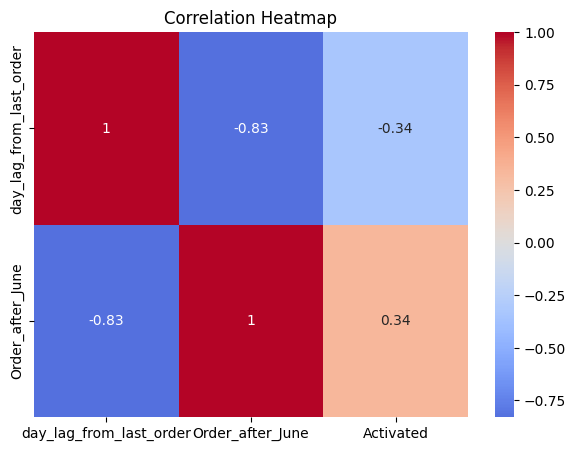

In [378]:
# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix.drop('Activated'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

Positive Correlation with Customer Activation:

    1. orders made after June 2021 (p=0.34, moderate)
    
    
Negative Correlation with Customer's Activation:

    1. day lag from the last order to t0 (p=-0.34, low)

Furtheremore the multicollinerity should be checked since it is evident that `Order_after_June` and 
`day_lag_from_last_order` are moderate negatively correlated.  

In [26]:
# Data preprocessing for the logistic regression
df['day_lag_from_last_order'].fillna(0, inplace=True)

In [27]:
# Selecting features and target
X = df[features+additional_features]
y = df['Activated']

In [28]:
# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                  Variable       VIF
0                 Cust_Age  5.889440
1                  Cust_NL  1.245990
2                   Orders  3.892106
3           Orders_Voucher  1.751446
4                is_female  2.948696
5  day_lag_from_last_order  2.742968
6         Order_after_June  3.579037


Based on its VIF higher than 5 and given the fact that its contribution to the Customer's Activation has been seen to be the lowest across the other predictors, `Cust_Age` is exclude from the logistic regression. 

### Logistic Regression to identify the predictors of the customer's activation

In [29]:
X = X.drop(columns='Cust_Age')

In [30]:
# Adding constant for the intercept
X = sm.add_constant(X)

# Logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.569839
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Activated   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Jun 2024   Pseudo R-squ.:                  0.1677
Time:                        13:02:44   Log-Likelihood:                -5698.4
converged:                       True   LL-Null:                       -6846.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.6386      0.079    -20.863      0.000      -1.793   

In [32]:
#coefficients odds ratios
coefficients = result.params
odds_ratios = np.exp(coefficients)
print(odds_ratios)

const                      0.194255
Cust_NL                    1.080378
Orders                     1.390813
Orders_Voucher             1.125482
is_female                  1.072326
day_lag_from_last_order    0.999444
Order_after_June           1.639575
dtype: float64


### Decision Trees/Random Forests: Can handle non-linear relationships and interactions between variables.

In [37]:
# Selecting features and target
X = df[features+additional_features]
y = df['Activated']

In [38]:
model2 = RandomForestClassifier(random_state=42)
model2.fit(X, y)


RandomForestClassifier(random_state=42)

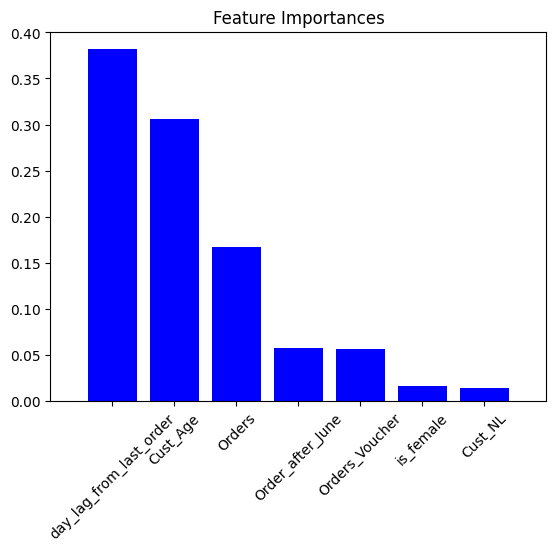

In [40]:
importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="blue", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()